# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Основная задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Знакомство с общей информацией датасета. 

In [1]:
import pandas as pd



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


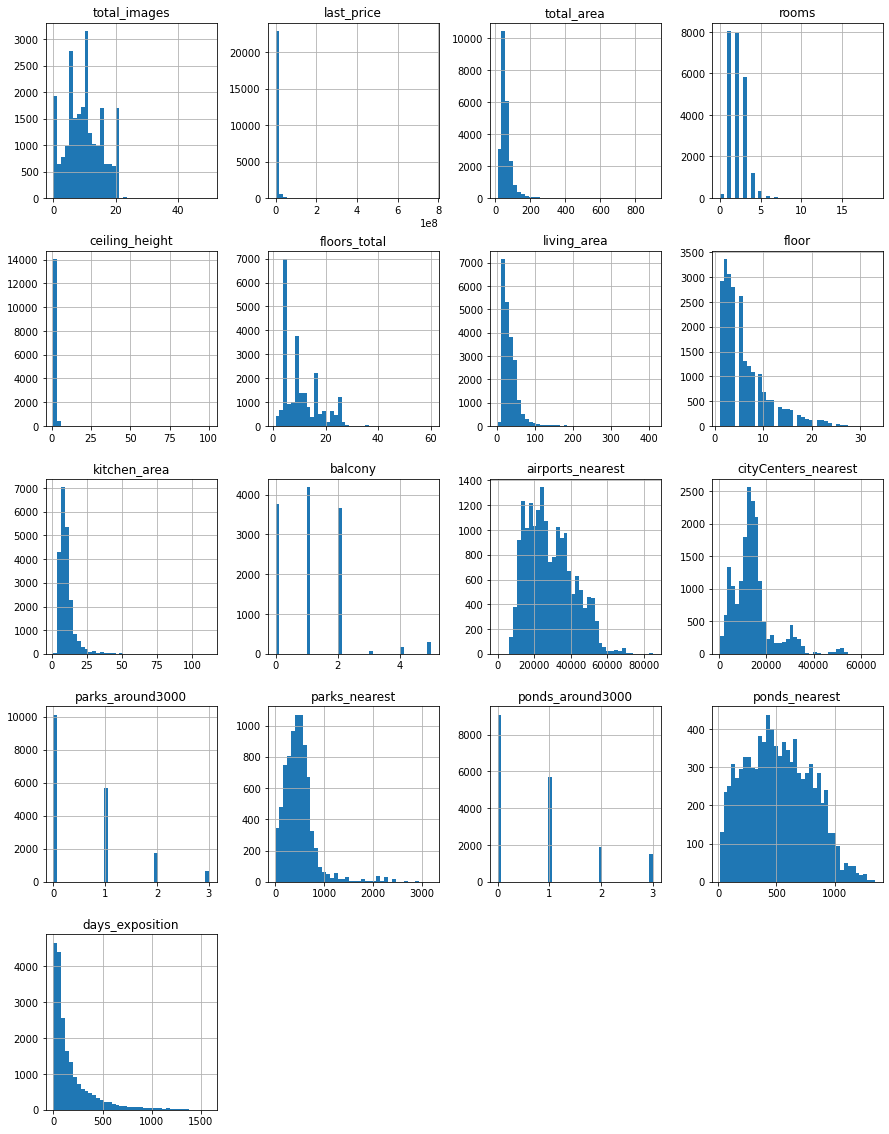

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
display(data.head())
data.hist(figsize=(15, 20), bins = 40);

### Предобработка данных

In [3]:
#Заполнение пропусков
data[['balcony', 'parks_around3000', 'ponds_around3000']] = data[['balcony', 'parks_around3000', 'ponds_around3000']].fillna(0)



<div class="alert alert-info">
<br> Причины пропуска данных:
    
1. Данные, добавляемые пользователями, могут быть неполными из-за незнания части предоставляемой информации, как то высота потолка, либо неочевидного формата заполнения формы, в случае со столбцом 'is_apartment'.
2. Справочные данные могут быть неполными или неактуальными и не покрывать все районы, объекты строительства.
</div>


In [4]:
#Изменение типов данных
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data[['last_price', 'balcony', 'parks_around3000', 'ponds_around3000']] = data[['last_price', 'balcony', 'parks_around3000', 'ponds_around3000']].astype('int')

<div class="alert alert-info">
<br> Причины изменения типов данных:
    
1. В столбце 'is_apartment' внесены булевые значения, логично поменять тип столбца на bool.
2. Столбец 'first_day_exposition' содержит дату, изменен на datetime.
3. Столбцы 'last_price', 'balcony', 'parks_around3000', 'ponds_around3000' - подразумевают целые числа, поменял на int.

</div>



In [5]:
#Удаляем неявные дубликаты
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')

<div class="alert alert-info">
<br>Удалил неявные дубликаты в столбце 'locality_name'.

Поменял "ё" на "е"; 'поселок городского типа' на 'поселок'; 'городской поселок' на 'поселок'
</div>



In [6]:
#Выбивающиеся значения
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] = data.loc[data['ceiling_height'] > 20, 'ceiling_height'] / 10
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()
data = data[(data['balcony'] <= 4) & (data['ceiling_height'] <= 6) &(data['total_area'] < 150) & (data['floors_total'] <=30) & (data['last_price'] < 20000000) & (data['rooms'] <= 5) & (data['living_area'] <= 110)]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20605 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20605 non-null  int64         
 1   last_price            20605 non-null  int64         
 2   total_area            20605 non-null  float64       
 3   first_day_exposition  20605 non-null  datetime64[ns]
 4   rooms                 20605 non-null  int64         
 5   ceiling_height        20605 non-null  float64       
 6   floors_total          20605 non-null  float64       
 7   living_area           20605 non-null  float64       
 8   floor                 20605 non-null  int64         
 9   is_apartment          20605 non-null  bool          
 10  studio                20605 non-null  bool          
 11  open_plan             20605 non-null  bool          
 12  kitchen_area          19839 non-null  float64       
 13  balcony         

<div class="alert alert-info">
<br>Удалил аномальные значения для 'balcony' - не более 4х, 'total_area' - не более 150 кв. м, 'floors_total' - не выше 30 этажа, 'last_price' - не дороже 20 млн. руб., 'rooms' не более 5, 'living_area' не больше 110 кв.м.
</div>

### Добавление в таблицу новых столбцов

In [7]:
data['price_per_metr'] = data['last_price'] / data['total_area']
data['price_per_metr'] = data['price_per_metr'].astype('int')
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data['floor_type'] = (
    data['floor']
    .where(data['floor'] != 1, 'первый')
    .where(data['floor'] != data['floors_total'], 'последний')
    .where((data['floor'] == 1) | (data['floor'] == data['floors_total']), 'другой')
    )
data['distance_to_center_km'] = round(data['cityCenters_nearest'] / 1000)
display(data.head())


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metr,weekday,month,year,floor_type,distance_to_center_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,True,...,482.0,2,755.0,NaN,120370,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.6,1,True,...,NaN,0,NaN,81.0,82920,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,True,...,90.0,2,574.0,558.0,92785,3,8,2015,другой,14.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,...,112.0,1,48.0,121.0,100000,1,6,2018,другой,8.0
5,10,2890000,30.4,2018-09-10,1,2.65,12.0,14.4,5,True,...,NaN,0,NaN,55.0,95065,0,9,2018,другой,NaN


### Проведение исследовательского анализа данных

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

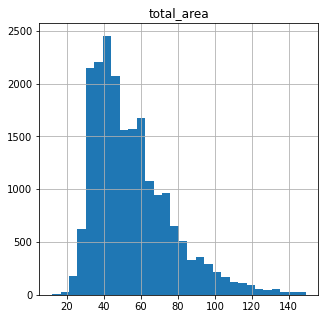

In [8]:
#Изучение параметров объектов и построение гистрограмм
data.hist(column='total_area',bins=30, figsize=(5,5))


<div class="alert alert-info">
<br>Наибольший объем объявлений приходится на квартиры площадью от 30 до 60 кв.м.
</div>

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

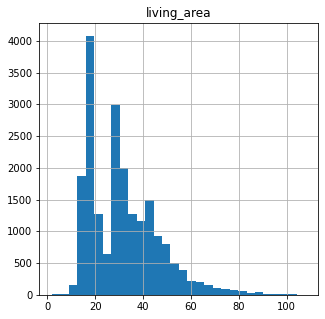

In [9]:
data.hist(column='living_area', bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>Объявления типовых квартир с жилой площадью 16-20 кв.м. и 25-30 кв.м. - в ТОПах.
<br>Квартир с жилплощадью более 90 метров - единыцы.
</div>

667


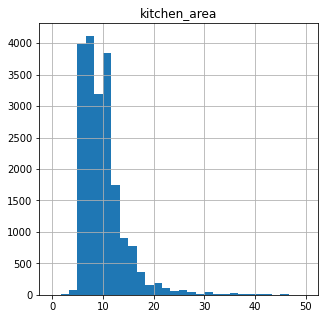

In [10]:
data.hist(column='kitchen_area',bins=30, figsize=(5,5), range=(0,50))
print(len(data[data['kitchen_area'] >= 20]['kitchen_area']))

Самая распространенная площадь кухни - 6 кв.м. - 1268 объявлений.
Что в 2 раза больше, чем объявлений с площадью кухни более 20 кв.м.
<div class="alert alert-info">
<br>Самая распространенная площадь кухни - 6 кв.м. - 1268 объявлений.
<br>Что почти в 2 раза больше, чем объявлений с площадью кухни более 20 кв.м. - 667 шт.
</div>

<AxesSubplot:>

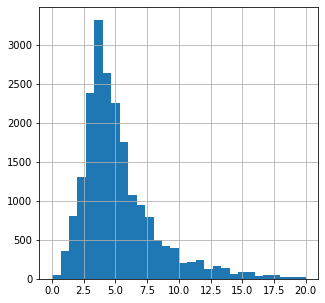

In [11]:
(data['last_price'] / 1000000).hist(bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>Самая популярная ценовая категория - 2.5-6 млн. руб. 
<br>Варианты дороже 10 млн. руб. тоже присутствуют в выборке, но их количество на порядок меньше.
</div>

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

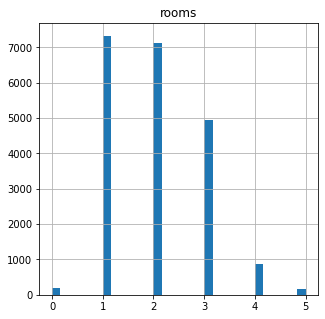

In [12]:
data.hist(column='rooms', bins=30, figsize=(5,5))
#print(data[data['rooms'] == 2]['rooms'].count())

<div class="alert alert-info">
<br>Квартиры-студии в явном меньшинстве наряду с пятикомнатными.
<br>Однушки с явным отрывом в 7327 объявлений лидируют в датасете.
<br>Двушки - на втором месте с показателем 7122 объекта.   
</div>

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

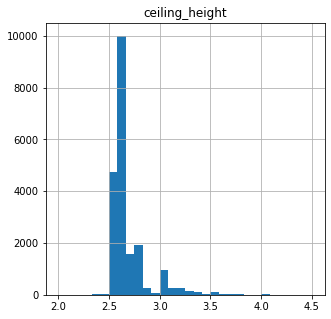

In [13]:
data.hist(column='ceiling_height', bins=30, figsize=(5,5), range=(2,4.5))

<div class="alert alert-info">
<br>Типовое значение высоты потолков в российских домах - в диапазоне 2.5 - 2.7 м.
<br>Таких почти 15 тысяч. 
</div>

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

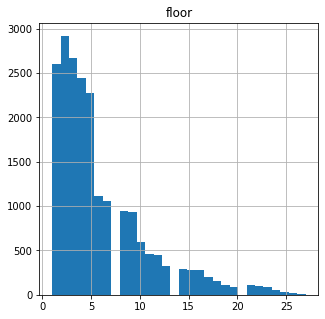

In [14]:
data.hist(column='floor', bins=30, figsize=(5,5))
plt.show()

<div class="alert alert-info">
<br>Большинство квартир находятся на 1-5 этажах. Самые популярные - второй и третий этажи.
</div>

<AxesSubplot:>

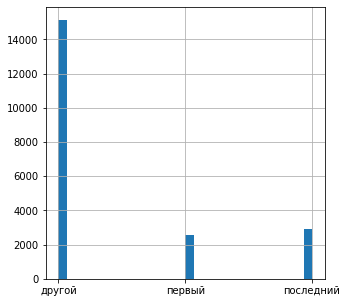

In [15]:
data['floor_type'].hist(bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>Большинство квартир находятся не на крайних этажах, 15К подобных объявлений.
<br>Первый этаж и последний распределились примерно поровну, 2.5 - 3К объявлений соответственно.
</div>

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

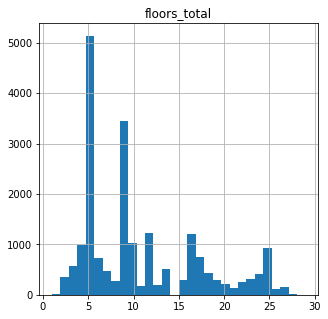

In [16]:
data.hist(column='floors_total',bins=30, figsize=(5,5))


<div class="alert alert-info">
<br>Пяти- и девятиэтажки самые распространенные, порядка 5100 и 3500 объявлений соответственно.
</div>

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

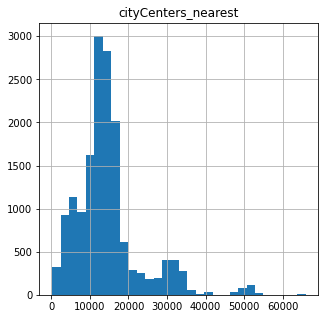

In [17]:
data.hist(column='cityCenters_nearest',bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>Большинство квартир находится на удалении 10-18 км от центра. 
</div>

array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

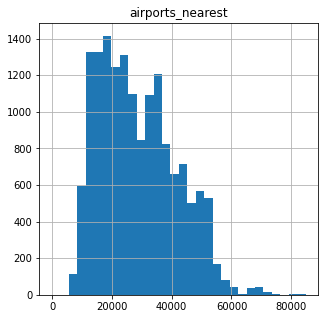

In [18]:
data.hist(column='airports_nearest', bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>12 - 24 км , а также 34 - 36 км до аэропорта - самые популярные значения расстояний до аэропорта.  
<br>Однако есть и те, кто живут совсем близко к аэропорту, на удалении 6-10 км.    
</div>

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

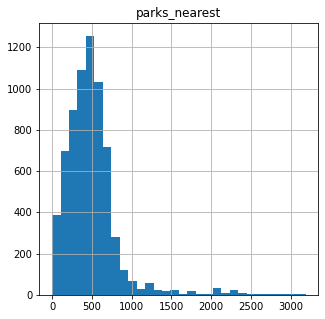

In [19]:
data.hist(column='parks_nearest', bins=30, figsize=(5,5))


<div class="alert alert-info">
<br>В радиусе 500 метров есть хотя бы один парк - и это самое популярное значение. 
<br>3937 квартир в пешей доступности от парка (до 500 м).  
</div>

array([[<AxesSubplot:title={'center':'weekday'}>]], dtype=object)

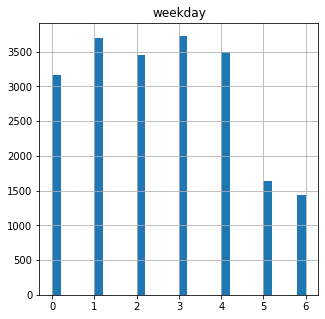

In [20]:
data.hist(column='weekday', bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>Повышенная активность к размещению объявлений приходится на вторник и четверг.
<br>В выходные активность падает в 2 раза.
</div>

array([[<AxesSubplot:title={'center':'month'}>]], dtype=object)

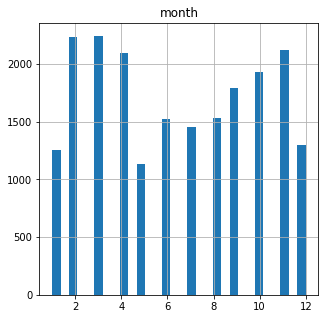

In [21]:
data.hist(column='month', bins=30, figsize=(5,5))

<div class="alert alert-info">
<br>Помесячная активность: с февраля по апрель и с сентября по ноябрь по нарастающей. 
</div>

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

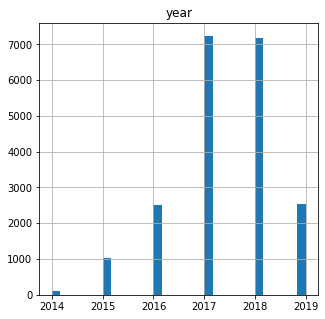

In [22]:
data.hist(column='year', bins=30, figsize=(5,5))

count    17911.000000
mean       181.083301
std        217.588541
min          1.000000
25%         44.000000
50%         98.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


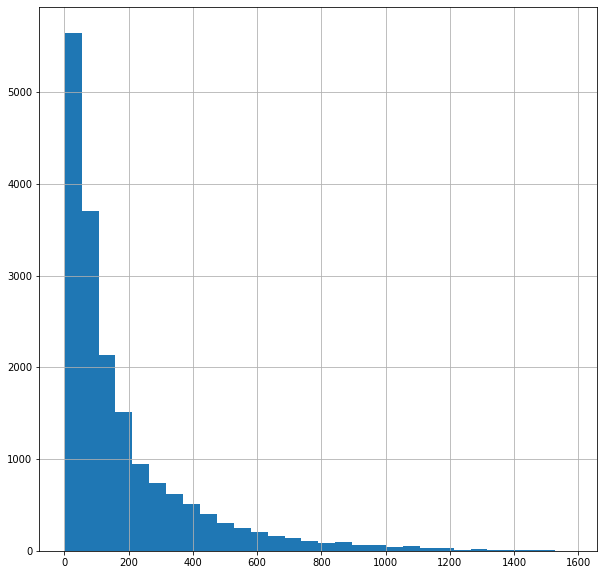

In [23]:
#Изучение данных по продолжительности продажи квартир
data['days_exposition'].hist(figsize=(10,10), bins=30)
print(data['days_exposition'].describe())


    В среднем длительность продажи квартиры состаявляет 181 день, медианное значение - 98 дней.
    Быстрыми продажами можно назвать те, которые закрылись за 50 дней.
    Нормальные - до 200 дней.
    От 200 до 800 - долгие.
    Необычайно долгими - те, что висят более 800 дней.

<AxesSubplot:>

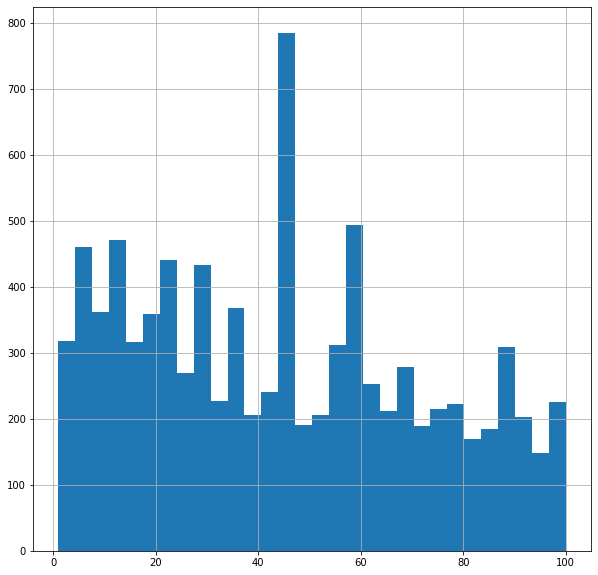

In [24]:
#факультативное исследование диапазона 0-100 дней.
data[data['days_exposition'] <= 100]['days_exposition'].hist(figsize=(10,10), bins=30)

In [25]:
#Факторы, влияющие на стоимость объекта
data_pivot = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'weekday', 'month', 'year', 'cityCenters_nearest']]
print(data_pivot.corr()['last_price'])


last_price             1.000000
total_area             0.762254
living_area            0.634453
kitchen_area           0.561006
rooms                  0.479576
weekday               -0.016279
month                  0.002991
year                  -0.018218
cityCenters_nearest   -0.357957
Name: last_price, dtype: float64


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

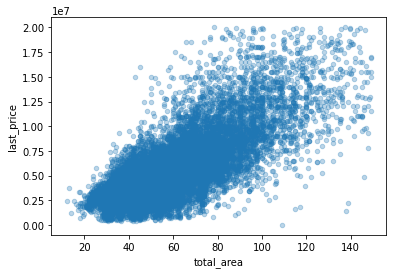

In [26]:
data_pivot.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

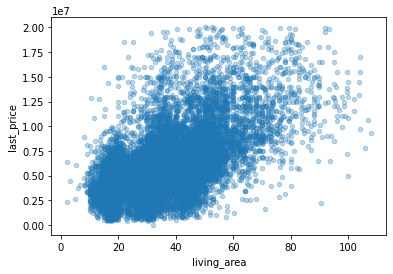

In [27]:
data_pivot.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

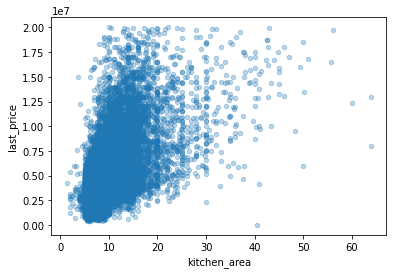

In [28]:
data_pivot.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='rooms'>

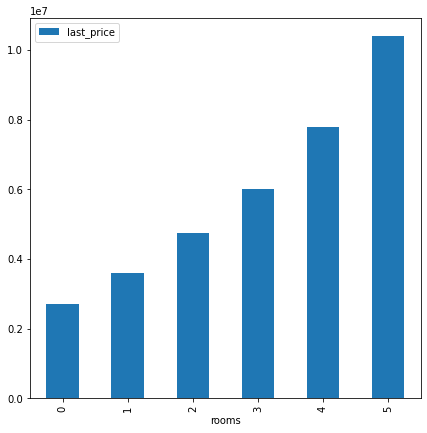

In [29]:
(data_pivot
 .pivot_table(index='rooms', values='last_price', aggfunc='median')
 .plot.bar(y='last_price', figsize=(7,7))
)

            last_price
floor_type            
другой         4700000
первый         3900000
последний      4190000


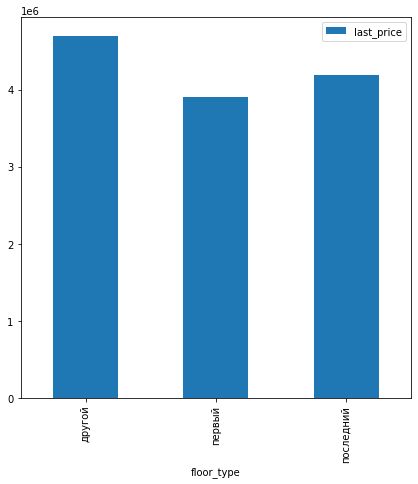

In [30]:
(data_pivot
 .pivot_table(index='floor_type', values='last_price', aggfunc='median')
 .plot.bar(y='last_price', figsize=(7,7))
)
print(data_pivot.pivot_table(index='floor_type', values='last_price', aggfunc='median'))

<AxesSubplot:xlabel='month'>

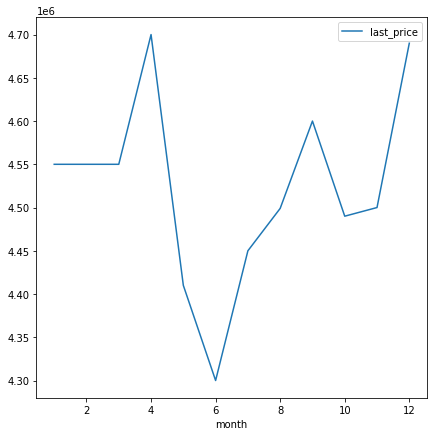

In [31]:
(data_pivot
 .pivot_table(index='month', values='last_price', aggfunc='median')
 .plot(figsize=(7,7))
)

<AxesSubplot:xlabel='weekday'>

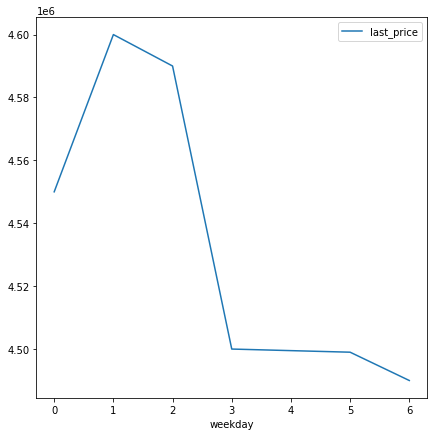

In [32]:
(data_pivot
 .pivot_table(index='weekday', values='last_price', aggfunc='median')
 .plot(figsize=(7,7))
)

      last_price
year            
2014     6295000
2015     5050000
2016     4368750
2017     4375000
2018     4500000
2019     4950000


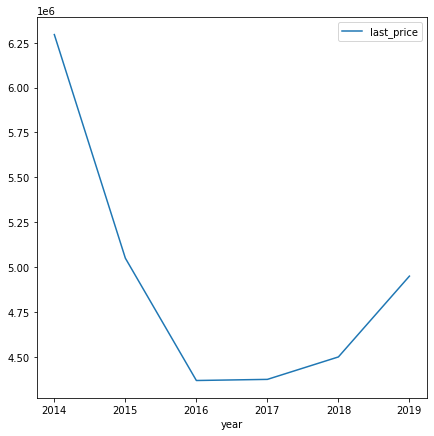

In [33]:
(data_pivot
 .pivot_table(index='year', values='last_price', aggfunc='median')
 .plot(figsize=(7,7))
)
print(data_pivot.pivot_table(index='year', values='last_price', aggfunc='median'))

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>

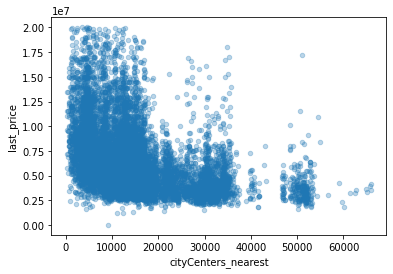

In [34]:
data_pivot.plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.3)

<div class="alert alert-info">
<br>Согласно получившися графикам и матрице корреляции вывод следующий:
<br>Цена сильнее всего зависит от метража квартиры и, как следствие, количества комнат.
<br>Не столь сильная, но все же зависимость есть для дня недели и месяца размещения объявления: пик цены приходится на апрель и вторую половину ноября, дно - в июне.
<br>Также хочу отметить, что этаж тоже влияет на ценообразование: квартиры на первых этажах ощутимо дешевле конкурентов.
<br>Год от года квартиры дорожают, падение стоимости в первые два года можно связать с нерепрезентативной выборкой.
    С 2016 по 2019 год медианная цена выросла на 15%.
</div>


In [35]:
#Средняя цена кв.м. ТОП-10
price_pivot = (
    data
    .pivot_table(index='locality_name', values='price_per_metr', aggfunc=('count', 'mean'))
    .astype('int')
    .sort_values('count', ascending=False)
    .head(10)
    .sort_values('mean', ascending=False)
)
display(price_pivot)

,count,mean
locality_name,,
Санкт-Петербург,13521,108482
Пушкин,332,102378
деревня Кудрово,258,93020
поселок Парголово,301,90442
поселок Мурино,484,86319
Петергоф,193,83898
поселок Шушары,399,78917
Колпино,320,75146
Гатчина,287,68548


<div class="alert alert-info"><br>Для 10 самых популярных населенных пунктов расклад следующий:
<br>Наибольшее количество объявлений в Санкт-Петербурге - 13525 шт. 
<br>Здесь же и самая высокая средняя цена кв. м. - 108482 руб.
<br>Наименьшая стоимость кв. м. отмечена во Всеволожске - 67331 руб.
</div>       

853649
-0.6083666610240106


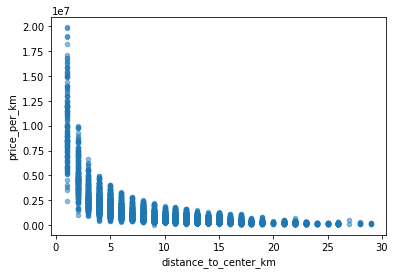

In [36]:
#Вычисление средней цены километра от центра
data_spb = data[data['locality_name'] == 'Санкт-Петербург']
data_spb = (
    data_spb
    .dropna(subset=['distance_to_center_km'])
)

data_spb = data_spb[data_spb['distance_to_center_km'] > 0]
data_spb['price_per_km'] = round(data_spb['last_price'] / data_spb['distance_to_center_km'])

print(data_spb['price_per_km'].mean().astype('int'))
data_spb.plot(x='distance_to_center_km', y='price_per_km', kind='scatter', alpha=0.5)
print(data_spb['price_per_km'].corr(data_spb['distance_to_center_km']))

    Согласно графику распределения с увеличением расстояния от центра цена метра уменьшается.
    Коэффциент Пирсона отрицательный, -0.6, что также говорит об обратной пропорции.

### Общий вывод

    На основании результатов, полученных в ходе исследования, можно сделать следующие выводы:
    Наибольший объем объявлений приходится на одно- и двухкомнатные квартиры площадью до 60 кв.м.
    Жилая площадь в таких объявлениях колеблется в пределах 15-35 кв. м.
    Пяти- и девятиэтажные квартиры - более трети всех объявлений.
    Расположение на крайних этажах негативно сказывается на ценообразовании: объекты, расположенные на первых этажах, в среднем на 17% дешевле квартир, расоложенных на средних этажах.
    Самый дорогой кв.м. в Санкт-Петербурге - 108482 руб, там же самое большое число объявлений - 13525 шт.

    Активность по размещению объявлений приходится на вторник и четверг, но в четверг размещались более дорогие квартиры.
    С мая по сентябрь активность по продаже снижается, похожая ситуация в январе.
    Покупки в основном совершаются в выхоные дни, пик - на 11 неделе.
    В 2017 г. размещений было больше: 7236 против 7191. Однако, медианная стоимость объекта выше в 2019 г. - 4950К руб.
    
    В среднем объявление висит 181 день, но также есть как срочные продажи до 50 дней (примерно 25% от общего количества),   так и экстра долгие более 800 дней.
    